In [51]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer
from massspecgym.tools.io import load_embeddings
from massspecgym.tools.data import get_embedding_for_node

import json
import os
from rdkit import Chem
from rdkit import RDLogger
import pandas as pd
import numpy as np
from collections import defaultdict, deque
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE


In [2]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [3]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [4]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [5]:
all_smiles = msn_dataset.smiles

In [6]:
len(all_smiles)

16476

In [7]:

unique_smiles = list(set(all_smiles))
print(f"Unique SMILES entries: {len(unique_smiles)}")

Unique SMILES entries: 13984


In [22]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

## Compare with JSON

In [55]:
# Suppress RDKit warnings for cleaner output
RDLogger.DisableLog('rdApp.*')

def canonicalize_smiles(smiles):
    """
    Canonicalize a SMILES string using RDKit.
    
    Parameters:
        smiles (str): The SMILES string to canonicalize.
    
    Returns:
        str or None: The canonical SMILES string, or None if invalid.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
        else:
            return None
    except:
        return None

def load_json_unique_smiles(json_path):
    """
    Load JSON data and create a mapping of canonical SMILES to their records.
    Keeps only the first occurrence of each canonical SMILES.
    
    Parameters:
        json_path (str): Path to the JSON file.
    
    Returns:
        dict: Mapping of canonical SMILES to JSON records.
    """
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"JSON file not found at path: {json_path}")
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    canonical_smiles_map = {}
    for record in data:
        smi = record.get('smiles', '').strip()
        canonical = canonicalize_smiles(smi)
        if canonical and canonical not in canonical_smiles_map:
            canonical_smiles_map[canonical] = record
    return canonical_smiles_map

def load_unique_smiles(smiles_list):
    """
    Extract unique SMILES from the dataset and canonicalize them.
    
    Parameters:
        smiles_list (list of smiles): Your dataset containing a 'smiles' column.
    
    Returns:
        dict: Mapping of original SMILES to their canonical forms.
    """

    canonical_map = {}
    for smi in smiles_list:
        canonical = canonicalize_smiles(smi)
        canonical_map[smi] = canonical
    return canonical_map

def match_smiles(canonical_msn_map, json_canonical_map):
    """
    Match canonical SMILES from the dataset to those in the JSON data.
    
    Parameters:
        canonical_msn_map (dict): Mapping of original SMILES to canonical SMILES from the dataset.
        json_canonical_map (dict): Mapping of canonical SMILES to JSON records.
    
    Returns:
        tuple: (matched_records, unmatched_smiles, match_count, unmatch_count, invalid_count)
    """
    matched = {}
    unmatched = []
    match_count = 0
    unmatch_count = 0
    invalid_count = 0
    
    for original_smi, canonical_smi in canonical_msn_map.items():
        if canonical_smi is None:
            invalid_count += 1
            unmatched.append(original_smi)
            continue
        if canonical_smi in json_canonical_map:
            matched[original_smi] = json_canonical_map[canonical_smi]
            match_count += 1
        else:
            unmatched.append(original_smi)
            unmatch_count += 1
    return matched, unmatched, match_count, unmatch_count, invalid_count


def get_ms_level(node) -> Optional[int]:
    """
    Return the ms_level from node's spectrum metadata if present.
    """
    if node is None or node.spectrum is None:
        return None
    ms_level_str = node.spectrum.get('ms_level')
    if ms_level_str is not None:
        return int(ms_level_str)
    return None


def gather_nodes_by_level_in_tree(tree) -> Dict[int, List]:
    """
    Gather all nodes from 'tree' grouped by their ms_level.
    Returns a dictionary: { ms_level (int) -> list of TreeNodes }.
    """
    nodes_by_level = defaultdict(list)

    # BFS to traverse the tree
    queue = deque([tree.root])
    while queue:
        node = queue.popleft()
        # Get ms_level from node
        lvl = get_ms_level(node)
        if lvl is not None:
            nodes_by_level[lvl].append(node)

        # Enqueue children
        for child in node.children.values():
            queue.append(child)

    return dict(nodes_by_level)  # Convert defaultdict -> normal dict

# Function to perform sampling
def sample_per_level(df: pd.DataFrame, max_samples: int) -> pd.DataFrame:
    """
    Randomly sample up to max_samples from each MS level.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with 'embedding' and 'ms_level' columns.
        max_samples (int): Maximum number of samples per MS level.
        
    Returns:
        pd.DataFrame: Sampled DataFrame.
    """
    # Group by 'ms_level'
    grouped = df.groupby('ms_level')
    
    # Apply sampling to each group
    sampled_df = grouped.apply(lambda x: x.sample(n=min(len(x), max_samples), random_state=42))
    
    # Remove the extra index introduced by groupby
    sampled_df.reset_index(drop=True, inplace=True)
    
    return sampled_df



In [14]:
json_path = '/Users/macbook/CODE/PyClassyFire/data/final_classification_results.json'

In [15]:
json_canonical_map = load_json_unique_smiles(json_path)
print(f"Total unique canonical SMILES in JSON: {len(json_canonical_map)}")

Total unique canonical SMILES in JSON: 13958


In [16]:
canonical_msn_map = load_unique_smiles(all_smiles)
total_unique = len(canonical_msn_map)
print(f"Total unique SMILES in your dataset: {total_unique}")

Total unique SMILES in your dataset: 13984


In [17]:
matched, unmatched, match_count, unmatch_count, invalid_count = match_smiles(canonical_msn_map, json_canonical_map)
print("\n=== Matching Results ===")
print(f"Total unique SMILES in your dataset: {total_unique}")
print(f"Matched SMILES: {match_count}")
print(f"Unmatched SMILES: {unmatch_count}")
print(f"Invalid SMILES: {invalid_count}")


=== Matching Results ===
Total unique SMILES in your dataset: 13984
Matched SMILES: 13407
Unmatched SMILES: 577
Invalid SMILES: 0


In [20]:
# For each tree in 'msn_dataset', gather nodes grouped by ms_level
dataset_levels_dict = {}

for tree in msn_dataset.trees:
    # Identify tree by the root's identifier
    root_id = "no_id"
    if tree.root and tree.root.spectrum:
        root_id = tree.root.spectrum.get('identifier')

    # Gather nodes by level
    nodes_by_level = gather_nodes_by_level_in_tree(tree)
    dataset_levels_dict[root_id] = nodes_by_level

In [26]:
# Initialize lists to store embeddings and corresponding levels
embeddings_list = []
levels_list = []

for tree_id, levels_dict in dataset_levels_dict.items():
    for level_str, nodes in levels_dict.items():
        ms_level = int(level_str)  
        for node in nodes:
            embedding = get_embedding_for_node(node, embeddings_dict)
            if embedding is not None:
                embeddings_list.append(embedding)
                levels_list.append(ms_level)
            else:
                # Nodes without embeddings
                pass


data = pd.DataFrame({
    'embedding': embeddings_list,
    'ms_level': levels_list
})

print(f"Total nodes with embeddings: {len(data)}")

Total nodes with embeddings: 183284


In [28]:
# Extract embeddings as a 2D NumPy array
X = np.vstack(data['embedding'].values)

# Extract MS level labels
y = data['ms_level'].values

In [41]:
# Initialize UMAP with desired parameters
# You can adjust n_neighbors and min_dist based on your dataset
umap_reducer = umap.UMAP(n_neighbors=20, min_dist=0.2, metric='cosine', random_state=42)

# Fit and transform the data
X_umap = umap_reducer.fit_transform(X)

# Add UMAP results to the DataFrame
data['UMAP_1'] = X_umap[:, 0]
data['UMAP_2'] = X_umap[:, 1]

print("UMAP dimensionality reduction completed.")

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP dimensionality reduction completed.


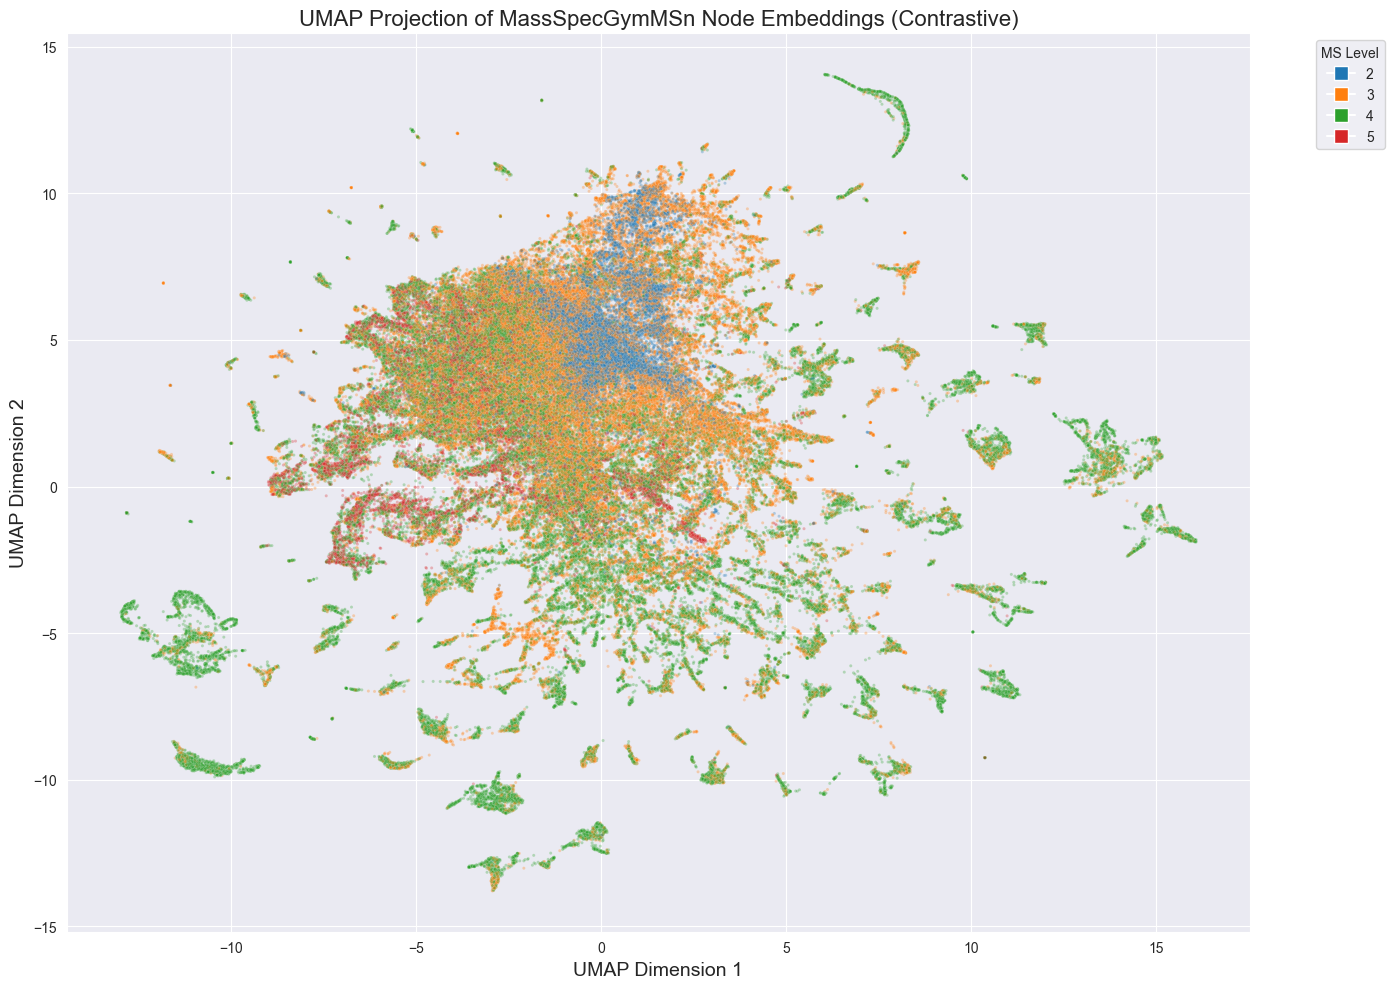

In [64]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Scatter plot with contrastive color palette and adjusted transparency
scatter = sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='ms_level',
    palette='tab10',  # Contrastive palette for better color differentiation
    data=data,
    legend='full',
    alpha=0.3,  # High transparency to reduce overlap effects
    s=5  # Smaller points to reduce clutter
)


# Enhance the plot with titles and labels
plt.title('UMAP Projection of MassSpecGymMSn Node Embeddings (Contrastive)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)


# Custom legend with larger square markers
legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lbl)
                 for lbl, col in zip(data['ms_level'].unique(), sns.color_palette('tab10', len(data['ms_level'].unique())))]

# Add the custom legend
plt.legend(handles=legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_65893/1027857376.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('ms_level').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)


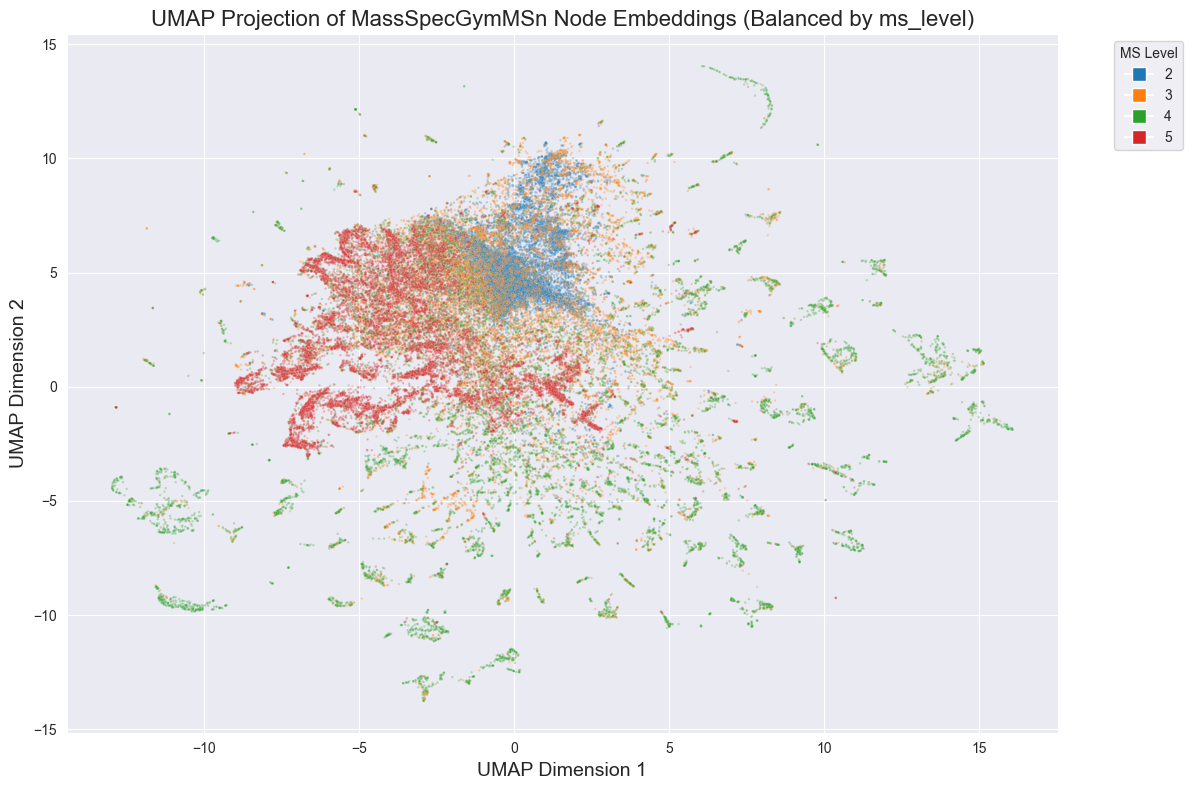

In [65]:
# Determine the minimum number of samples across all ms_levels
min_samples = data['ms_level'].value_counts().min()

# Balance the dataset by sampling min_samples from each ms_level
balanced_data = data.groupby('ms_level').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

# Plot the balanced data
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='ms_level',
    palette='tab10',  
    data=balanced_data,
    legend='full',
    alpha=0.3,  # Adjust transparency to reduce overlap
    s=3  # Adjust point size
)

plt.title('UMAP Projection of MassSpecGymMSn Node Embeddings (Balanced by ms_level)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)

# Custom legend with larger square markers
legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lbl)
                 for lbl, col in zip(data['ms_level'].unique(), sns.color_palette('tab10', len(data['ms_level'].unique())))]

# Add the custom legend
plt.legend(handles=legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

### TSNE

In [66]:
# Define the maximum number of samples per MS level
max_samples_per_level = 10000

# Perform sampling
sampled_data = sample_per_level(data, max_samples_per_level)

print(f"Sampled data contains {len(sampled_data)} nodes across {sampled_data['ms_level'].nunique()} MS levels.")

Sampled data contains 40000 nodes across 4 MS levels.


/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_65893/3874203115.py:146: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = grouped.apply(lambda x: x.sample(n=min(len(x), max_samples), random_state=42))


In [67]:
# Extract embeddings as a 2D NumPy array
X_sampled = np.vstack(sampled_data['embedding'].values)

# Extract MS level labels
y_sampled = sampled_data['ms_level'].values

In [68]:
# Initialize t-SNE with optimized parameters for speed
tsne = TSNE(
    n_components=2,
    perplexity=30,          # You can adjust based on dataset size and structure
    learning_rate=200,      # Common default
    n_iter=1000,            # Number of iterations
    random_state=42,
    metric='cosine',
    verbose=1               # To monitor progress
)

X_tsne_sampled = tsne.fit_transform(X_sampled)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.009s...


/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 40000 samples in 28.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for sample 13000 / 40000
[t-SNE] Computed conditional probabilities for sample 14000 / 4000

In [69]:
# Add t-SNE results to the sampled DataFrame
sampled_data['tSNE_1'] = X_tsne_sampled[:, 0]
sampled_data['tSNE_2'] = X_tsne_sampled[:, 1]

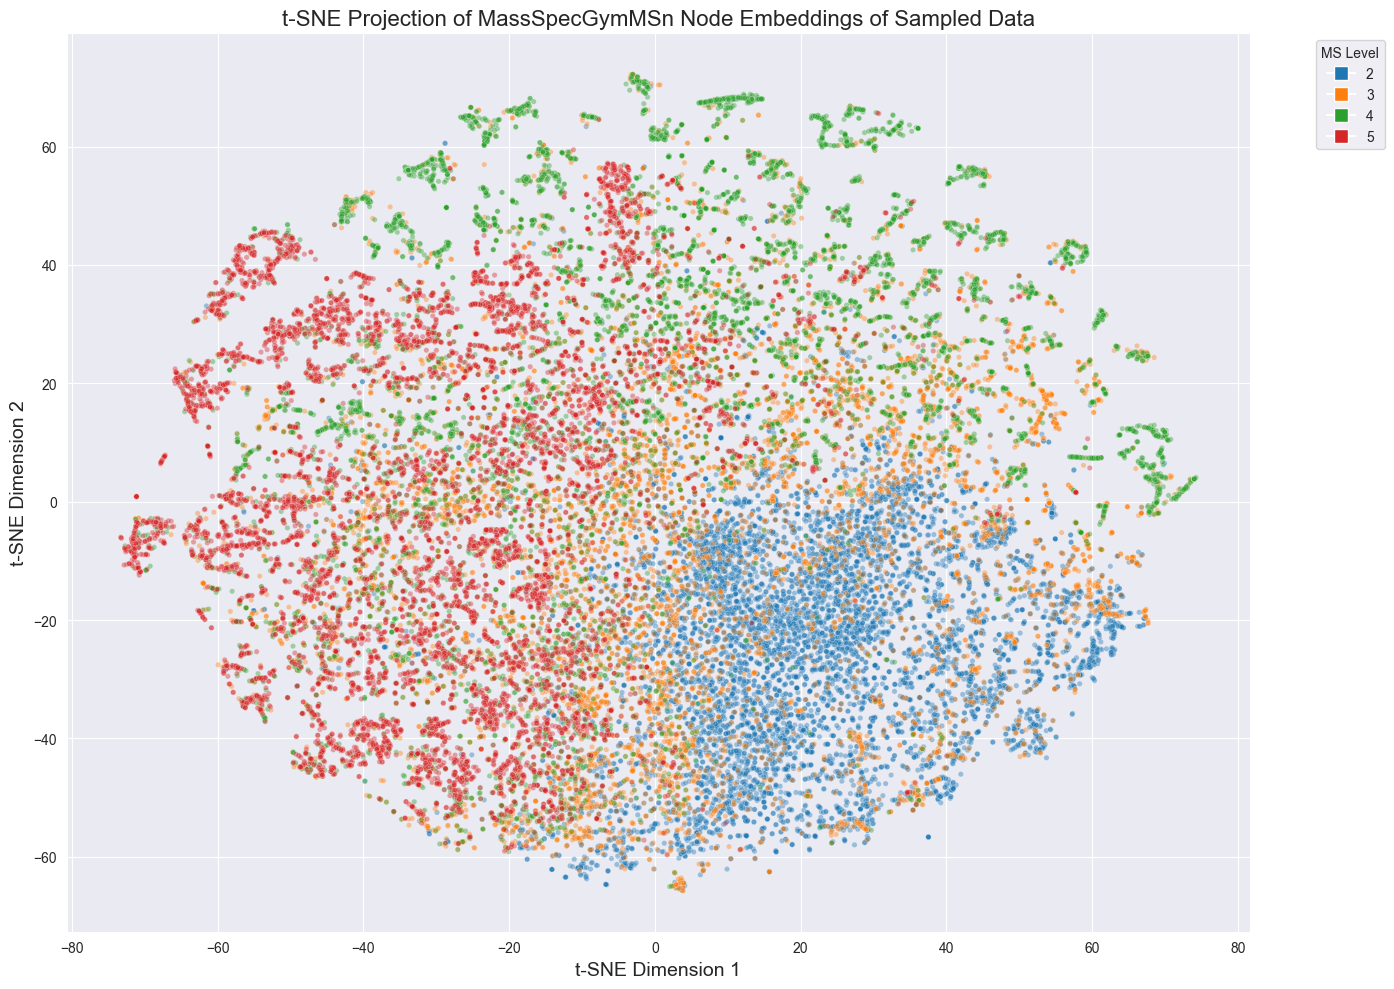

In [70]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Scatter plot with contrastive color palette and adjusted transparency
sns.scatterplot(
    x='tSNE_1',
    y='tSNE_2',
    hue='ms_level',
    palette='tab10',  # Contrastive palette for better color differentiation
    data=sampled_data,
    legend='full',
    alpha=0.4,  # High transparency to reduce overlap effects
    s=15  # Smaller points to reduce clutter
)


# Enhance the plot with titles and labels
plt.title('t-SNE Projection of MassSpecGymMSn Node Embeddings of Sampled Data', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)

# Custom legend with larger square markers
legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lbl)
                 for lbl, col in zip(data['ms_level'].unique(), sns.color_palette('tab10', len(data['ms_level'].unique())))]

# Add the custom legend
plt.legend(handles=legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Initialize t-SNE with desired parameters
# You can adjust perplexity and learning_rate based on your dataset
# tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42, metric='euclidean')
# 
# # Fit and transform the data
# X_tsne = tsne.fit_transform(X)
# 
# # Add t-SNE results to the DataFrame
# data['tSNE_1'] = X_tsne[:, 0]
# data['tSNE_2'] = X_tsne[:, 1]
# 
# print("t-SNE dimensionality reduction completed.")

In [49]:

import json
from glob import glob

# Path to the directory containing the processed ClassyFire files
predicted_dir = '/Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/predicted'

# Load the original unique SMILES
# Assuming you have saved `unique_smiles` to a file or have it in your current environment
# If it's in your current environment as a list, you can convert it to a set for faster lookup
# Here, we'll assume you have it in a CSV or TXT file. Adjust accordingly.

# Example: Loading from a previously saved TSV file
# unique_smiles_file = '/path/to/unique_smiles.tsv'
# unique_smiles = set(pd.read_csv(unique_smiles_file, sep='\t', header=None)[0].tolist())

unique_smiles_set = set(unique_smiles)
print(f"Total unique SMILES in original dataset: {len(unique_smiles_set)}")

# Initialize variables to collect data
all_processed_smiles = set()
all_attributes = set()
file_attributes = {}  # To store attributes per file

# Iterate over all files in the predicted directory
# Assuming files have extensions .csv or .json
for file_path in glob(os.path.join(predicted_dir, '*')):
    filename = os.path.basename(file_path)
    file_ext = os.path.splitext(filename)[1].lower()
    
    print(f"\nProcessing file: {filename} (Format: {file_ext})")
    
    try:
        if file_ext == '.csv' or file_ext == '.tsv':
            # Determine the separator based on file extension
            sep = ',' if file_ext == '.csv' else '\t'
            df = pd.read_csv(file_path, sep=sep)
            print(f"Loaded CSV/TSV with {df.shape[0]} rows and {df.shape[1]} columns.")
            
            # Assuming SMILES are in a column named 'SMILES' or similar
            # Adjust the column name based on your actual data
            smiles_col = None
            for col in df.columns:
                if 'smiles' in col.lower():
                    smiles_col = col
                    break
            if smiles_col is None:
                print(f"Warning: No SMILES column found in {filename}. Skipping this file.")
                continue
            
            smiles = df[smiles_col].dropna().astype(str).str.strip().tolist()
            all_processed_smiles.update(smiles)
            file_attributes[filename] = set(df.columns)
            
        elif file_ext == '.json':
            with open(file_path, 'r') as f:
                data = json.load(f)
            print(f"Loaded JSON with {len(data)} records.")
            
            # Assuming each JSON object has a key for SMILES, e.g., 'smiles'
            # Adjust based on your actual JSON structure
            smiles = []
            for entry in data:
                # Adjust the key if necessary
                if 'smiles' in entry:
                    smiles.append(entry['smiles'].strip())
                else:
                    # Try other possible keys or skip
                    possible_keys = ['SMILES', 'smiles_string', 'smile']
                    for key in possible_keys:
                        if key in entry:
                            smiles.append(entry[key].strip())
                            break
            all_processed_smiles.update(smiles)
            # Collect all keys as attributes
            all_keys = set()
            for entry in data:
                all_keys.update(entry.keys())
            file_attributes[filename] = all_keys
            
        else:
            print(f"Unsupported file format for {filename}. Skipping.")
            continue
        
        # Collect attributes
        all_attributes.update(file_attributes[filename])
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

# Summary of attributes across all files
print("\nSummary of attributes across all processed files:")
for filename, attrs in file_attributes.items():
    print(f"{filename}: {attrs}")

# Check if all files have the same attributes
attribute_sets = list(file_attributes.values())
first_attr_set = attribute_sets[0] if attribute_sets else set()
consistent_attributes = all(attr_set == first_attr_set for attr_set in attribute_sets)
if consistent_attributes:
    print("\nAll processed files have consistent attributes.")
else:
    print("\nInconsistencies found in file attributes:")
    for filename, attrs in file_attributes.items():
        if attrs != first_attr_set:
            print(f"{filename} has different attributes: {attrs}")

# Verify that all processed SMILES are in the original unique_smiles
missing_smiles = all_processed_smiles - unique_smiles_set
extra_smiles = all_processed_smiles - unique_smiles_set

if not missing_smiles and not extra_smiles:
    print("\nAll processed SMILES are present in the original unique SMILES list.")
else:
    if missing_smiles:
        print(f"\nWarning: {len(missing_smiles)} SMILES in processed files are NOT in the original dataset.")
        # Optionally, list them
        print(f"Missing SMILES: {list(missing_smiles)[:10]}{'...' if len(missing_smiles) > 10 else ''}")
    if extra_smiles:
        print(f"\nWarning: {len(extra_smiles)} SMILES in processed files are NOT in the original dataset.")
        # Optionally, list them
        print(f"Extra SMILES: {list(extra_smiles)[:10]}{'...' if len(extra_smiles) > 10 else ''}")

# Final report
print("\nFinal Report:")
print(f"Total unique SMILES in original dataset: {len(unique_smiles_set)}")
print(f"Total unique SMILES in processed files: {len(all_processed_smiles)}")
print(f"Missing SMILES in processed files: {len(unique_smiles_set - all_processed_smiles)}")
print(f"Extra SMILES in processed files: {len(all_processed_smiles - unique_smiles_set)}")
print(f"Total unique attributes across all files: {len(all_attributes)}")
print(f"Consistent attributes across all files: {consistent_attributes}")


Processing file: query_12021244.json (Format: .json)
Loaded JSON with 7 records.
Error processing query_12021244.json: 'str' object has no attribute 'keys'

Processing file: query_12021264.json (Format: .json)
Loaded JSON with 7 records.
Error processing query_12021264.json: 'str' object has no attribute 'keys'

Processing file: 12021270.csv (Format: .csv)
Loaded CSV/TSV with 26863 rows and 3 columns.

Processing file: 12021271.csv (Format: .csv)
Loaded CSV/TSV with 27060 rows and 3 columns.

Processing file: 12021273.csv (Format: .csv)
Loaded CSV/TSV with 26855 rows and 3 columns.

Processing file: 12021272.csv (Format: .csv)
Loaded CSV/TSV with 27122 rows and 3 columns.

Processing file: 12021276.csv (Format: .csv)
Loaded CSV/TSV with 26546 rows and 3 columns.

Processing file: 12021275.csv (Format: .csv)
Loaded CSV/TSV with 27090 rows and 3 columns.

Processing file: 12021274.csv (Format: .csv)
Loaded CSV/TSV with 26959 rows and 3 columns.

Processing file: query_12021261.json (For

NameError: name 'unique_smiles_set' is not defined

In [40]:
# Define the maximum number of SMILES per file
max_per_file = 1000

# Calculate the number of files needed
num_files = (len(unique_smiles) + max_per_file - 1) // max_per_file
print(f"Number of TSV files to create: {num_files}")

Number of TSV files to create: 14


In [41]:
import os

In [42]:
# Define the output directory
output_dir = '/Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Split the SMILES list and save each chunk
for i in range(num_files):
    start_idx = i * max_per_file
    end_idx = start_idx + max_per_file
    chunk = unique_smiles[start_idx:end_idx]
    
    # Define the filename
    filename = f'classyfire_upload_{i+1}.tsv'
    filepath = os.path.join(output_dir, filename)
    
    # Save the chunk to TSV without headers and without index
    pd.Series(chunk).to_csv(filepath, sep='\t', index=False, header=False)
    
    print(f"Saved {len(chunk)} SMILES to {filepath}")

Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_1.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_2.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_3.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_4.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_5.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_6.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_7.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_8.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_9.tsv
Saved 1000 SMILES to /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/classyfire_upload_10.tsv
Saved 100

In [43]:
# Create a DataFrame with ID and SMILES columns
df_unique = pd.DataFrame({
    'SMILES': unique_smiles
})

# Display the first few entries to verify
df_unique.head()

,SMILES
0,COC1=C(C=CC(=C1)C(=O)O)O[C@H]2[C@@H]([C@H]([C@...
1,CCCCC(=O)O[C@H](CC(=O)O)C[N+](C)(C)C
2,CCN1C=C(C(=N1)C(=O)N)NC(=S)NC2=C(C=CC(=C2)Cl)OC
3,COC1=C(C=CC(=C1)/C=N\NC2=CC=CC=C2C(=O)O)OCC3=C...
4,CCOC(=O)CSC1=NN=C(N1C)C2=CN(N=C2OC)C


In [44]:
output_file = '/Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/unique_smiles.tsv'
# df_unique.to_csv(output_file, sep='\t', index=False)

print(f"TSV file saved as {output_file}")

TSV file saved as /Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/unique_smiles.tsv


In [45]:
output_file_no_header = '/Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/unique_valid_smiles_no_header.tsv'
df_unique.to_csv(output_file_no_header, sep='\t', index=False, header=False)
print(f"TSV file saved as '{output_file_no_header}' without headers.")

TSV file saved as '/Users/macbook/CODE/Majer:MassSpecGym/data/ClassyFire/unique_valid_smiles_no_header.tsv' without headers.


In [25]:
# Read the TSV file back to verify
df_check = pd.read_csv(output_file, sep='\t')
print(df_check.head())
print(f"Total entries in TSV: {len(df_check)}")

                                              SMILES
0  COC1=C(C=CC(=C1)C(=O)O)O[C@H]2[C@@H]([C@H]([C@...
1               CCCCC(=O)O[C@H](CC(=O)O)C[N+](C)(C)C
2    CCN1C=C(C(=N1)C(=O)N)NC(=S)NC2=C(C=CC(=C2)Cl)OC
3  COC1=C(C=CC(=C1)/C=N\NC2=CC=CC=C2C(=O)O)OCC3=C...
4               CCOC(=O)CSC1=NN=C(N1C)C2=CN(N=C2OC)C
Total entries in TSV: 100


TSV file size: 0.93 MB
